1. Import Libraires
2. Import Model for transfer_learning
3. Freeze few layers 
4. Add and make modifications for Out put layer to suit our specific use case
5. Compile and fit on training dataset
6. Check accuracy graphs and evaluate model perofrmance
7. Test on new datasets

## Import Libraries

In [1]:
#import keras
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import tensorflow.keras as K
import os
import cv2

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.applications import inception_v3,vgg16,vgg19,resnet

from tensorflow.keras import applications # https://www.tensorflow.org/api_docs/python/tf/keras/applications
from tensorflow.keras import models # https://www.tensorflow.org/api_docs/python/tf/keras/models
from tensorflow.keras import layers # https://keras.io/api/layers/
from tensorflow.keras import optimizers # https://keras.io/api/optimizers/
from keras.utils import normalize

import pandas as pd
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
#from keras.utils import np_utils
from keras import utils as np_utils
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
pd.set_option('display.max_columns',None)#displaying long list of columns
pd.set_option('display.max_rows', None)#displaying long list of rows
pd.set_option('display.width', 1000)#width of window

### Creating a Training Dataset
With Folder structure, we can create our training dataset and assign labels to each type of item

In [2]:
training_data=[]
IMG_SIZE=224
def create_training():
    Datadir=os.path.join(os.getcwd(),"Dataset")
    Categories=['Pizza','Soda','Bagel']
    # Get into each folder
    for cat in Categories:
        path=os.path.join(Datadir,cat)
        # For each image at Path
        for img in os.listdir(path):
            try:
                img=cv2.imread(os.path.join(path,img))
                newimg=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
                training_data.append([newimg,Categories.index(cat)])
            except Exception as e:
                print('err')
                pass   
    return training_data
tr=create_training()

Defined Categories

In [3]:
# Categories=['Pizza','Soda','Bagel','Burger','Burrito','Donuts','Fries']
Categories=['Pizza','Soda','Bagel']
print("Category_code for Pizza is :",Categories.index('Pizza'))
print("Category_code for Soda is :",Categories.index('Soda'))
print("Category_code for Bagel is :",Categories.index('Bagel'))
# print("Category_code for Burger is :",Categories.index('Burger'))
# print("Category_code for Burrito is :",Categories.index('Burrito'))
# print("Category_code for Donuts is :",Categories.index('Donuts'))
# print("Category_code for Fries is :",Categories.index('Fries'))

Category_code for Pizza is : 0
Category_code for Soda is : 1
Category_code for Bagel is : 2


In [8]:
training_data[100][0]

array([[[180, 161, 204],
        [179, 161, 205],
        [177, 163, 209],
        ...,
        [233, 207, 213],
        [235, 209, 215],
        [236, 210, 216]],

       [[181, 161, 204],
        [180, 162, 206],
        [178, 164, 210],
        ...,
        [233, 207, 213],
        [234, 209, 215],
        [235, 209, 215]],

       [[182, 163, 205],
        [181, 164, 207],
        [180, 167, 211],
        ...,
        [232, 206, 212],
        [233, 207, 213],
        [233, 207, 213]],

       ...,

       [[124, 108, 131],
        [122, 108, 132],
        [119, 108, 136],
        ...,
        [170, 200, 254],
        [183, 206, 255],
        [188, 209, 255]],

       [[120, 104, 127],
        [119, 105, 129],
        [117, 106, 134],
        ...,
        [170, 199, 253],
        [182, 206, 254],
        [187, 208, 255]],

       [[119, 103, 126],
        [118, 103, 128],
        [117, 105, 133],
        ...,
        [169, 199, 253],
        [182, 205, 254],
        [187, 208, 255]]

In [9]:
Categories[training_data[100][1]]

'Pizza'

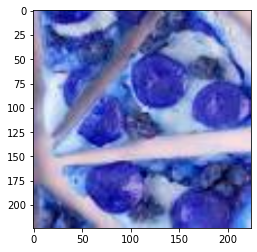

In [12]:
import matplotlib.pyplot as plt
plt.imshow(training_data[100][0])
# plt.imshow(X[2])

In [13]:
import random
random.shuffle(training_data)

X=[]
Y=[]

for features,target in training_data:
    X.append(features)
    Y.append(target)
    
Y=np.array(Y)
X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,3)
X.shape

(305, 224, 224, 3)

In [14]:
Y.shape

(305,)

In [15]:
X[0].shape

(224, 224, 3)

In [ ]:
# data_augmentation = tf.keras.Sequential([
#      layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#      layers.experimental.preprocessing.RandomRotation(0.2)])
# image=X[2]
# image = tf.expand_dims(image, 0)
# plt.figure(figsize=(10, 10))

# for i in range(3):
#     augmented_image = data_augmentation(image)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_image[0])
#     plt.axis("off")

In [20]:
# load vgg16 backbone
backbone = K.applications.VGG16(
    weights="imagenet",  # load weights pre-trained on imagenet
    input_shape=(224, 224, 3), # set input shape per imagenet
    include_top=False, # do not include the vgg16 classifier at the top.
)  

# freeze the backbone
backbone.trainable = False

flat = layers.Flatten()(backbone.output)
cls = layers.Dense(512, activation="relu")(flat)
cls = layers.Dense(units=3, activation="softmax", name="clshead")(cls)

model = models.Model(
    inputs=backbone.input,
    outputs=cls) 

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001), 
    loss={'clshead': 'sparse_categorical_crossentropy'},
    loss_weights={'clshead': 1.0},
    metrics={'clshead': 'accuracy'}, 
)

In [21]:
# get model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [22]:
X=normalize(X)
Y = K.utils.to_categorical(Y,3)
history=model.fit(X,Y,validation_split=0.3,batch_size=8,epochs=10)

Epoch 1/10
27/27 [==============================] - 111s 4s/step - loss: 1.4269 - accuracy: 0.7418 - val_loss: 0.4551 - val_accuracy: 0.8696
Epoch 2/10
27/27 [==============================] - 94s 4s/step - loss: 0.2209 - accuracy: 0.9202 - val_loss: 0.8511 - val_accuracy: 0.8152
Epoch 3/10
27/27 [==============================] - 98s 4s/step - loss: 0.2458 - accuracy: 0.9296 - val_loss: 0.5530 - val_accuracy: 0.8370
Epoch 4/10
27/27 [==============================] - 112s 4s/step - loss: 0.1401 - accuracy: 0.9437 - val_loss: 0.4191 - val_accuracy: 0.9022
Epoch 5/10
27/27 [==============================] - 116s 4s/step - loss: 0.2745 - accuracy: 0.9249 - val_loss: 0.5928 - val_accuracy: 0.8696
Epoch 6/10
27/27 [==============================] - 137s 5s/step - loss: 0.0473 - accuracy: 0.9718 - val_loss: 0.5849 - val_accuracy: 0.8804
Epoch 7/10
27/27 [==============================] - 120s 4s/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.6162 - val_accuracy: 0.8804
Epoch 8/10
27/2

In [23]:
Y_onehot = K.utils.to_categorical(Y,3)
Y_onehot

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1